In [1]:
import numpy as np
A = np.arange(4).reshape((2, 2))
d = np.array((1, 2))
D = np.diag(d)
B = D.dot(A)
d2 = np.expand_dims(d, -1)
C = d2 * A
E = np.dot(A, d)

# now try multiplying the same rank 2 matrix by a stack of vectors
I = np.eye(2)
I[1,1] += 1
B = np.arange(20).reshape((-1, 2))
G = np.einsum('jk,ik->ji', B, I)

# now try multiplying a stack of matrices by a stack of matrices
F = np.tile(I, (5,1,1))
for i in range(5):
    F[i,1,0] += i
H = np.einsum('ijk,ilk->ijl', F, F)

# now try multiplying a stack of matrices by a stack of diagonal (vectors, but interpreted as matrices)
D2 = np.tile(np.array((2, 1)), (5, 1))
U = np.einsum('ijk,ik->ijk', F, D2)

# now try multiplying by the diagonal
ones = np.ones(4).reshape((2, 2))
L = np.einsum('ij,j->ij', ones, d)

# PRINTS
print(H)

[[[ 1.  0.]
  [ 0.  4.]]

 [[ 1.  1.]
  [ 1.  5.]]

 [[ 1.  2.]
  [ 2.  8.]]

 [[ 1.  3.]
  [ 3. 13.]]

 [[ 1.  4.]
  [ 4. 20.]]]


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
import numpy as np
A = tf.constant(np.arange(8).reshape((2, 2, 2)))
d = tf.constant(np.arange(4).reshape((2, 2)) + 1)
D = tf.linalg.diag(d)
B = tf.matmul(D, A)
d2 = tf.expand_dims(d, -1)
C = d2 * A
E = tf.einsum('ijk,ik->ij', A, d)

# test making a stacked identity
I_ = tf.expand_dims(tf.eye(3), 0)
I = tf.tile(I_, (5, 1, 1))

# testing matrix_band_part
G = tf.constant(np.random.normal(size=(5, 3, 3)))
G_ld = tf.matrix_band_part(G, -1, 0) - tf.matrix_band_part(G, 0, 0)
G_ud = tf.einsum('ijk->ikj', G_ld)

with tf.Session() as sess:
    items = sess.run([G_ld, G_ud])
    
for i in items:
    print(i)
    print(i.shape)
    print('-' * 15)

[[[ 0.          0.          0.        ]
  [-0.61180171  0.          0.        ]
  [-1.56147443  0.37673571  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.36183258  0.          0.        ]
  [-0.6330636  -0.63548132  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.17439752  0.          0.        ]
  [-1.6113619   2.12958014  0.        ]]

 [[ 0.          0.          0.        ]
  [ 1.30301825  0.          0.        ]
  [-0.34095166  0.71795532  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.01971448  0.          0.        ]
  [-1.33264416 -0.63415442  0.        ]]]
(5, 3, 3)
---------------
[[[ 0.         -0.61180171 -1.56147443]
  [ 0.          0.          0.37673571]
  [ 0.          0.          0.        ]]

 [[ 0.         -0.36183258 -0.6330636 ]
  [ 0.          0.         -0.63548132]
  [ 0.          0.          0.        ]]

 [[ 0.          0.17439752 -1.6113619 ]
  [ 0.          0.          2.12958014]
  [ 0.          0.          0.        ]]

In [3]:
# TEST IF eigh() IS DIFFERENTIABLE
A = tf.Variable(np.random.normal(size=(5, 5)))
A = tf.matmul(A, A, transpose_b=True)
e, v = tf.linalg.eigh(A)
loss = tf.linalg.norm(tf.einsum('ij,kj->ik', tf.einsum('ij,j->ij', v, e), v) - tf.cast(tf.eye(5), tf.float64))
e, v = e[::-1], v[:, ::-1]
error = tf.linalg.norm(tf.einsum('ij,kj->ik', tf.einsum('ij,j->ij', v, e), v) - A)

opt = tf.train.AdamOptimizer()
step = opt.minimize(loss)

# initialize
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    for i in range(10000):
        loss_, error_, _ = sess.run([loss, error, step])
        if i % 1000 == 0:
            print(i, loss_, error_)
        
    A_ = sess.run(A)
    
print(A_)

Instructions for updating:
Colocations handled automatically by placer.
0 12.068689516077246 7.131616785230269e-15
1000 1.7631240192168431 4.374627298898541e-15
2000 0.000716749056934651 2.402990748351512e-15
3000 0.0005189859941272456 2.10533691070388e-15
4000 0.0004200907617477899 1.9724606899282014e-15
5000 0.00046897385254747036 1.9423512149414333e-15
6000 0.00030362292299335614 1.688871130867313e-15
7000 0.00035917987919628007 1.5093497719070133e-15
8000 0.00038823040068722563 3.2145977674591333e-15
9000 0.00047949057504672037 2.2771894857520546e-15
[[ 9.99943609e-01  5.72849899e-06  1.21823217e-04  2.65964792e-05
   4.52704354e-06]
 [ 5.72849899e-06  1.00000071e+00 -5.90438939e-06  4.01475258e-07
  -8.20055669e-07]
 [ 1.21823217e-04 -5.90438939e-06  9.99688115e-01 -4.53500352e-05
   1.80124924e-05]
 [ 2.65964792e-05  4.01475258e-07 -4.53500352e-05  9.99991682e-01
   6.26560424e-06]
 [ 4.52704354e-06 -8.20055669e-07  1.80124924e-05  6.26560424e-06
   1.00000981e+00]]


In [4]:
# TEST MATRIX STACK x MATRIX STACK
n_stacks = 10
n = 10

# generate matrices
matrices = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    product = np.dot(matrix, matrix.T)
    matrices.append(matrix)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
product_stack = np.einsum('ijk,ilk->ijl', matrix_stack, matrix_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i,:,:])
    diffs.append(diff)
    
print(sum(diffs))

-2.1790728943482662e-14


In [5]:
# TEST MATRIX STACK x VECTOR STACK (REPRESENTING DIAGONALS)
n_stacks = 10
n = 10

# generate matrices
matrices = []
diagonals = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    diagonal = np.random.normal(size=(n,))
    product = np.dot(matrix, np.diag(diagonal))
    matrices.append(matrix)
    diagonals.append(diagonal)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
diagonals_stack = np.concatenate([np.expand_dims(d, axis=0) for d in diagonals], axis=0)
product_stack = np.einsum('ijk,ik->ijk', matrix_stack, diagonals_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i,:,:])
    diffs.append(diff)
    
print(sum(diffs))

0.0


In [6]:
# TEST MATRIX STACK x VECTOR STACK (REPRESENTING ACTUAL VECTORS)
n_stacks = 10
n = 10

# generate matrices
matrices = []
vectors = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    vector = np.random.normal(size=(n,))
    product = np.dot(matrix, vector)
    matrices.append(matrix)
    vectors.append(vector)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
vectors_stack = np.concatenate([np.expand_dims(v, axis=0) for v in vectors], axis=0)
product_stack = np.einsum('ijk,ik->ij', matrix_stack, vectors_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i])
    diffs.append(diff)
    
print(sum(diffs))

3.969047313034935e-15


In [7]:
# check numpy broadcasting for row sums
n = 100
x = np.random.normal(size=(n, 100000)) ** 2
x /= np.expand_dims(np.sum(x, axis=1), -1)
print(np.sum(x))

100.00000000000004


In [8]:
# check tf broadcasting for row sums
n = 100
e = tf.constant(np.random.normal(size=(n, 10000)) ** 2)
eps = 1e-8
pre_e_t = 1/(e + eps)
e_t = pre_e_t / tf.expand_dims(tf.reduce_sum(pre_e_t, axis=1), -1) #*tf.expand_dims(tf.reduce_sum(e, axis=1), -1)
e_t_sum = tf.reduce_sum(e_t)
e_t_max = tf.maximum(e_t, 20)
with tf.Session() as sess:
    a = sess.run(e_t_max)

In [51]:
# test if our home-made distance function is correct
import numpy as np
from scipy.spatial.distance import cdist

d = 10
n_A = 150
n_B = 320
A = np.random.normal(size=(n_A, d))
B = np.random.normal(size=(n_B, d))

def pairwise_dists(A, B):
    r_A, r_B = np.sum(A*A, 1), np.sum(B*B, 1)

    # turn r into column vector
    r_A, r_B = np.reshape(r_A, [-1, 1]), np.reshape(r_B, [-1, 1])
    D = r_A - 2 * np.matmul(A, np.transpose(B)) + np.transpose(r_B)
    
    return D

def tf_pairwise_dists(A, B):
    r_A, r_B = tf.reduce_sum(A*A, axis=1), tf.reduce_sum(B*B, axis=1)

    # turn r into column vector
    r_A, r_B = tf.reshape(r_A, [-1, 1]), tf.reshape(r_B, [-1, 1])
    D = r_A - 2 * tf.matmul(A, tf.transpose(B)) + tf.transpose(r_B)
    
    return D

D1 = np.sqrt(pairwise_dists(A, B))
D2 = cdist(A, B)
print(np.linalg.norm(D1 - D2))

8.696384818268271e-14


In [52]:
top = tf.nn.top_k(-D1, k=1)
with tf.Session() as sess:
    A_ = sess.run(top)
    
print(A_)

TopKV2(values=array([[-2.26117082],
       [-2.88857906],
       [-2.73920364],
       [-2.28149381],
       [-1.93490619],
       [-1.82265576],
       [-1.55965444],
       [-2.31400322],
       [-2.15424972],
       [-2.27176589],
       [-1.83201495],
       [-1.69428806],
       [-2.43927659],
       [-1.62745525],
       [-1.85440146],
       [-1.9322539 ],
       [-2.41330013],
       [-2.5358286 ],
       [-1.55975619],
       [-1.83351951],
       [-2.64704676],
       [-2.34503854],
       [-1.7414713 ],
       [-2.25154267],
       [-1.1715082 ],
       [-2.1541664 ],
       [-1.34783342],
       [-1.67870223],
       [-1.90614263],
       [-1.91815044],
       [-2.72806838],
       [-2.06373229],
       [-2.37779231],
       [-2.07834204],
       [-2.08003617],
       [-1.26015168],
       [-2.45694549],
       [-2.53453817],
       [-1.42764826],
       [-1.60238816],
       [-1.89706649],
       [-2.71793409],
       [-1.75953662],
       [-2.11758322],
       [-1.9840014

In [53]:
D = pairwise_dists(A, A) + 1e-6

k = 2
vals, idxs = tf.nn.top_k(-D, k=k)
a = tf.reshape(vals, (-1, 1))
range_A = tf.expand_dims(tf.range(idxs.shape[0]), -1)
p = tf.expand_dims(tf.random.uniform(shape=(tf.shape(idxs)[0],), maxval=k, dtype=tf.dtypes.int32), -1)
p = tf.concat([range_A, p], axis=1)
idx = tf.gather_nd(idxs, p)
idx = tf.expand_dims(idx, -1)
A_ = tf.gather_nd(A, idx)
RES = tf.linalg.norm(A_ - A)

with tf.Session() as sess:
    RES_ = sess.run(a)
    
print(RES_)

[[-1.00000000e-06]
 [-6.55607956e+00]
 [-1.00000000e-06]
 [-7.25260100e+00]
 [-9.99999996e-07]
 [-6.47165663e+00]
 [-1.00000000e-06]
 [-7.22018527e+00]
 [-1.00000000e-06]
 [-2.31833852e+00]
 [-1.00000000e-06]
 [-3.66549425e+00]
 [-1.00000000e-06]
 [-4.62922866e+00]
 [-1.00000000e-06]
 [-5.65705394e+00]
 [-1.00000000e-06]
 [-5.49333111e+00]
 [-1.00000000e-06]
 [-5.26725047e+00]
 [-1.00000000e-06]
 [-5.06093613e+00]
 [-1.00000000e-06]
 [-3.39005575e+00]
 [-9.99999993e-07]
 [-6.52135255e+00]
 [-9.99999998e-07]
 [-3.30410260e+00]
 [-1.00000000e-06]
 [-3.95761562e+00]
 [-1.00000000e-06]
 [-2.74902900e+00]
 [-1.00000000e-06]
 [-7.28499644e+00]
 [-1.00000000e-06]
 [-7.12018352e+00]
 [-1.00000000e-06]
 [-2.74728815e+00]
 [-1.00000001e-06]
 [-2.13562514e+00]
 [-9.99999996e-07]
 [-6.34649495e+00]
 [-1.00000000e-06]
 [-6.54948683e+00]
 [-1.00000000e-06]
 [-3.22831273e+00]
 [-9.99999996e-07]
 [-5.01710683e+00]
 [-1.00000000e-06]
 [-4.23589920e+00]
 [-1.00000000e-06]
 [-8.28893192e+00]
 [-1.0000000

In [12]:
import matplotlib.pyplot as plt
plt.imshow(D)
plt.show()

<Figure size 640x480 with 1 Axes>

In [13]:
small = tf.expand_dims(np.arange(9).reshape((3,3)), 1)
bigger = tf.tile(small, [1, 3, 1])
bigger = tf.reshape(bigger, (9, 3))
with tf.Session() as sess:
    bigger_ = sess.run(bigger)
    
print(bigger_)

[[0 1 2]
 [0 1 2]
 [0 1 2]
 [3 4 5]
 [3 4 5]
 [3 4 5]
 [6 7 8]
 [6 7 8]
 [6 7 8]]


In [14]:
n = 4
W = np.random.normal(size=(n, n))
W = np.dot(W, W.T)
print("symmetric (should be zero):", np.linalg.norm(W - W.T))
# normalize rows
row_norm = np.expand_dims(np.sum(W, axis=1), axis=-1)
col_norm = np.sum(W, axis=0)

print(np.sum(W / col_norm, axis=0))
print(np.sum(W / row_norm, axis=1))

W = W / row_norm / col_norm
print(np.sum(W, axis=1))
print(np.sum(W, axis=0))

W /= np.expand_dims(np.sum(W, axis=1), axis=-1)
print(np.sum(W, axis=1))
print(np.sum(W, axis=0))

symmetric (should be zero): 0.0
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[0.15322013 0.1210527  0.1105338  0.12548569]
[0.15322013 0.1210527  0.1105338  0.12548569]
[1. 1. 1. 1.]
[1.02228805 0.92734343 0.97838807 1.07198045]


In [106]:
n = 4
W = tf.random.normal(shape=(n, n))
W = tf_pairwise_dists(W, W) + 1e-8
W = tf.Print(W, [tf.linalg.norm(W - tf.transpose(W))], "symmetric (should be zero):", summarize=n)
# normalize rows
row_norm = 1 / tf.reduce_sum(W, axis=1)
col_norm = 1 / tf.reduce_sum(W, axis=0)

W = tf.Print(W, [tf.reduce_sum(tf.einsum('i,ij->ij', row_norm, W), axis=1), tf.reduce_sum(tf.einsum('j,ij->ij', col_norm, W), axis=0)], summarize=n)

W2 = tf.einsum('j,ij->ij', col_norm, tf.einsum('i,ij->ij', row_norm, W))
W = W * tf.expand_dims(row_norm, -1) * col_norm
W = tf.Print(W, [tf.reduce_sum(W, axis=0), tf.reduce_sum(W, axis=1), tf.linalg.norm(W - W2), tf.linalg.norm(row_norm - col_norm)], summarize=n)
W = tf.Print(W, [tf.linalg.norm(W - tf.transpose(W))], "symmetric (should be zero):", summarize=n)

# check row normalization
# row_norm = tf.sqrt(1 / tf.reduce_sum(W, axis=1))
row_norm = 1 / tf.reduce_sum(W, axis=1)
row_norm = tf.Print(row_norm, [row_norm], 'row_norm ', summarize=n)
inv_sqrt_row_norm = tf.sqrt(row_norm)
sqrt_row_norm = tf.sqrt(tf.reduce_sum(W, axis=1))
L = tf.einsum('j,ij->ij', inv_sqrt_row_norm, tf.einsum('i,ij->ij', inv_sqrt_row_norm, W))
W2 = tf.einsum('i,ij->ij', row_norm, W)
W = W * tf.expand_dims(row_norm, -1)
W = tf.Print(W, [tf.reduce_sum(W, axis=0), tf.reduce_sum(W, axis=1), tf.linalg.norm(W - W2), tf.linalg.norm(W - tf.transpose(W))], summarize=n)

# check D^{-1/2} W D^{-1/2} normalization
# W2 = tf.einsum('j,ij->ij', row_norm, tf.einsum('i,ij->ij', row_norm, W))
# W = tf.matmul(tf.diag(row_norm), tf.matmul(W, tf.diag(row_norm)))
# W = tf.Print(W, [tf.reduce_sum(W, axis=0), tf.reduce_sum(W, axis=1), tf.linalg.norm(W - W2), tf.linalg.norm(W - tf.transpose(W))], summarize=n)
# W = tf.matmul(tf.diag(row_norm), tf.matmul(W, tf.diag(1/row_norm)))
# W = tf.Print(W, [tf.reduce_sum(W, axis=0), tf.reduce_sum(W, axis=1), tf.linalg.norm(W - tf.transpose(W))], summarize=n)

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    W_ = sess.run(W)
    srn = sess.run(sqrt_row_norm)
    L_ = sess.run(L)
    
print(W_)
print(np.sum(W_, axis=1))
# W_ = np.eye(W.shape[0]) - W_
ones = np.ones(shape=(W.shape[0], 1))
W_sym = np.matmul(W_.T, W_)
print(np.matmul(W_sym, ones))
print(np.matmul(W_, ones))
print(np.matmul(W_, (ones.T * srn).T) - (ones.T * srn).T)

[[ 0.0000000e+00  3.8073483e-01  3.0626357e-01  3.1300160e-01]
 [ 4.1816333e-01 -7.2831597e-08  4.3941957e-01  1.4241715e-01]
 [ 2.6227877e-01  3.4262878e-01 -1.6959081e-08  3.9509246e-01]
 [ 3.4623232e-01  1.4343661e-01  5.1033103e-01  0.0000000e+00]]
[1.         0.99999994 1.         1.        ]
[[1.02667439]
 [0.86680017]
 [1.25601417]
 [0.85051121]]
[[1.        ]
 [0.99999997]
 [0.99999998]
 [0.99999997]]
[[ 0.0271401 ]
 [-0.03605703]
 [-0.01188252]
 [ 0.02164198]]


In [314]:
e, v = np.linalg.eig(L_)

# test reconstruction
L_recon = np.einsum('ij,jk->ik', v, np.einsum('i,ji->ij', e, v))
L_recon2 = np.matmul(np.matmul(v, np.diag(e)), v.T)

print(np.linalg.norm(L_recon - L_), np.linalg.norm(L_recon2 - L_recon))

print('right eigenvectors of W_ (should be ones):', np.matmul(W_, ones))
print('right eigenvectors of L_:', v[:,0])
print('right eigenvectors of W_ in terms of the right eigenvectors of L_ (should be ones again):', (v * srn)[:,0])
print('right eigenvectors of W_ in terms of the right eigenvectors of L_ (should be ones again):', v[:,0] * srn)

8.476087e-08 6.0818046e-08
right eigenvectors of W_ (should be ones): [[1.        ]
 [0.99999997]
 [0.99999998]
 [0.99999997]]
right eigenvectors of L_: [-0.48367858 -0.55225116 -0.4842495  -0.4760001 ]
right eigenvectors of W_ in terms of the right eigenvectors of L_ (should be ones again): [-0.08431511 -0.09626873 -0.08441464 -0.0829766 ]
right eigenvectors of W_ in terms of the right eigenvectors of L_ (should be ones again): [-0.08431511 -0.12307178 -0.09819028 -0.0828991 ]


In [337]:
n = 10
W = np.random.normal(loc=0, scale=.1, size = (n, n))
W = dists = pairwise_dists(W, W)
W = np.exp(-W)
D_inv = np.diag(1 / np.sum(W, axis=1))

# row and column normalize W
W = D_inv.dot(W.dot(D_inv))

# compute P
D_inv = np.diag(1 / np.sum(W, axis=1))
P = D_inv.dot(W)

# compute L
D_half_inv_diag = 1 / np.sqrt(np.sum(W, axis=1))
D_half_inv = np.diag(1 / np.sqrt(np.sum(W, axis=1)))
D_half = np.diag(np.sqrt(np.sum(W, axis=1)))
L = D_half_inv.dot(W.dot(D_half_inv))

e, v = np.linalg.eig(L)

L_recon = np.einsum('ij,jk->ik', v, np.einsum('i,ji->ij', e, v))
L_recon2 = np.matmul(np.matmul(v, np.diag(e)), v.T)

print(np.linalg.norm(L_recon - L), np.linalg.norm(L_recon2 - L_recon))

print('right eigenvectors of P (should be ones):', np.matmul(P, np.ones(shape=(P.shape[0], 1))))
norm_v = v[:,0] / np.sum(v[:,0])
print('right eigenvectors of L:', norm_v)
print('right eigenvectors of P in terms of the right eigenvectors of L (should be ones again):', norm_v.dot(D_half_inv))
print('right eigenvectors of P in terms of the right eigenvectors of L (should be ones again):', norm_v * D_half_inv_diag)

1.0748792367693698e-15 1.962615573354719e-17
right eigenvectors of P (should be ones): [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
right eigenvectors of L: [0.10012462 0.09994385 0.10004801 0.09994893 0.10006458 0.10002137
 0.099961   0.09994247 0.0999486  0.09999659]
right eigenvectors of P in terms of the right eigenvectors of L (should be ones again): [0.29113972 0.29113972 0.29113972 0.29113972 0.29113972 0.29113972
 0.29113972 0.29113972 0.29113972 0.29113972]
right eigenvectors of P in terms of the right eigenvectors of L (should be ones again): [0.29113972 0.29113972 0.29113972 0.29113972 0.29113972 0.29113972
 0.29113972 0.29113972 0.29113972 0.29113972]


In [338]:
D_half_inv_diag.reshape((-1,1))

array([[2.90777357],
       [2.9130329 ],
       [2.91000023],
       [2.91288491],
       [2.90951828],
       [2.91077508],
       [2.91253307],
       [2.91307318],
       [2.91289442],
       [2.91149656]])

In [339]:
A = v / np.sum(v, axis=0) * D_half_inv_diag
A[:,0]

array([0.29113972, 0.29061408, 0.29091694, 0.29062885, 0.29096513,
       0.2908395 , 0.29066395, 0.29061006, 0.2906279 , 0.29076743])

In [344]:
v2 = np.einsum('ij,j->ij', v, np.sum(v, axis=0)/n)
print(v2[:,0])
print(norm_v)
A1 = (v / np.sum(v, axis=0)).dot(np.diag(D_half_inv_diag))
A1[:,0]

[0.10012458 0.09994381 0.10004797 0.09994889 0.10006454 0.10002134
 0.09996096 0.09994243 0.09994856 0.09999655]
[0.10012462 0.09994385 0.10004801 0.09994893 0.10006458 0.10002137
 0.099961   0.09994247 0.0999486  0.09999659]


array([0.29113972, 0.29061408, 0.29091694, 0.29062885, 0.29096513,
       0.2908395 , 0.29066395, 0.29061006, 0.2906279 , 0.29076743])

In [305]:
dhi = 1 / np.sqrt(np.sum(W, axis=1))
print(norm_v.shape, dhi.shape)

(1000,) (1000,)


In [306]:
ep, vp = np.linalg.eig(P)
vp_recon = np.einsum('ij,i->ij', v, dhi)
vp_recon /= np.sum(vp_recon)
# vp_recon = np.einsum('j,ij->ij', 1 / np.sum(vp_recon, axis=0), vp_recon)
vp_recon.shape

(1000, 1000)

In [307]:
# vp =  np.einsum('j,ij->ij', 1 / np.sum(vp, axis=0), vp)
vp /= np.sum(vp)
vp.shape

(1000, 1000)

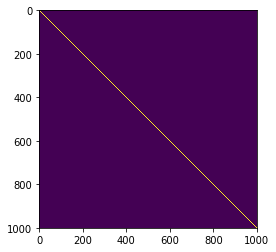

In [308]:
plt.imshow(W)

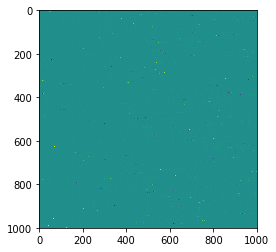

In [309]:
plt.imshow(vp_recon)

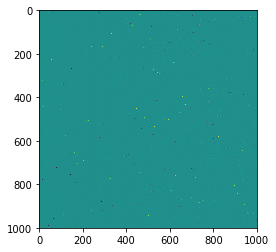

In [310]:
plt.imshow(vp)

0.03510634688392554
0.003992463368198303


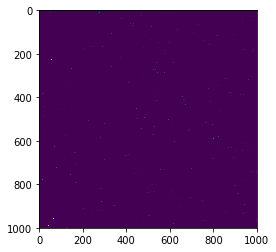

In [312]:
K = ((vp - vp_recon) ** 2)
print(np.linalg.norm(K))
plt.imshow(K)
print(np.max(K))

In [16]:
# TEST COVARIANCES
A = np.tile(np.expand_dims(np.eye(3)[:2,:], 0), (10, 1, 1))
A
# print(A.shape)
A = A.reshape((20, 3))
# # print(A.shape)
# A = A.reshape((10, 2, 3))
# A

In [17]:
A = np.random.normal(size=(10, 5))
B = A / np.expand_dims(np.max(A, axis=1), -1)
print(B)
A = tf.constant(A)
A = tf.einsum('ij,i->ij', A, 1 / tf.reduce_max(A, axis=1))

# A = A / tf.reduce_max(A, axis=1)

with tf.Session() as sess:
    A_ = sess.run(A)
    
print(A_ - B)

[[-0.71586751  1.         -0.0301248   0.31671609  0.32620004]
 [ 0.17436255  0.19458683  0.0195182   1.          0.51681995]
 [ 1.         -2.43087017 -0.35302695  0.92159325 -0.37959642]
 [ 0.21305953  0.43095311  1.          0.95601262 -1.43274257]
 [-0.43081822  0.90182098 -0.29106806 -0.16643888  1.        ]
 [ 0.29522254 -0.36733985 -0.50272836  1.         -0.75886295]
 [ 0.09396666 -0.20277342  0.26149851  1.          0.1574349 ]
 [ 1.         14.12615889  9.47706931 12.96352402  4.2433389 ]
 [-0.72118987 -3.50241387  1.         -0.26855569 -0.11572035]
 [ 0.66873708  1.         -0.97331328  0.3846003  -1.5748628 ]]
[[-1.11022302e-16  0.00000000e+00 -3.46944695e-18  5.55111512e-17
   0.00000000e+00]
 [ 0.00000000e+00 -2.77555756e-17 -3.46944695e-18  0.00000000e+00
  -1.11022302e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.22044605e-16]
 [ 0.00000000e+00  0.00000000

In [18]:
A = np.random.normal(size=(10,5))
np.mean(A, axis=1).shape

(10,)